In [263]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf              # Importation for using Yahoo finance
import datetime
import pandas as pd
import seaborn as sns
import csv
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from IPython.display import clear_output
import statsmodels.api as sm

chemin_fichier1_csv = "/content/BCOMGC.csv"
df = pd.read_csv(chemin_fichier1_csv)
df = df[["Date", "Dernier"]]

chemin_fichier2_csv = "/content/BCOMSI.csv"
df2 = pd.read_csv(chemin_fichier2_csv)
df2 = df2[["Date", "Dernier"]]
df = pd.merge(df, df2, on="Date", how="outer")
df = df.rename(columns={"Dernier_x": "Cours Gold"})
df = df.rename(columns={"Dernier_y": "Cours Silver"})

print(df)

            Date Cours Gold Cours Silver
0     29/12/2023     209,77       201,56
1     28/12/2023     210,96       203,96
2     27/12/2023     211,93       206,21
3     26/12/2023     209,57       204,16
4     22/12/2023     209,50       205,57
...          ...        ...          ...
1253  08/01/2019     151,66       154,28
1254  07/01/2019     152,13       154,70
1255  04/01/2019     151,65       154,99
1256  03/01/2019     152,71       155,10
1257  02/01/2019     151,45       153,65

[1258 rows x 3 columns]


In [264]:
df['Cours Gold'] = df['Cours Gold'].str.replace(',', '.').astype(float)
df['Cours Silver'] = df['Cours Silver'].str.replace(',', '.').astype(float)




df['Date'] = pd.to_datetime(df['Date'], format ="%d/%m/%Y")


df = df.sort_values(by='Date')


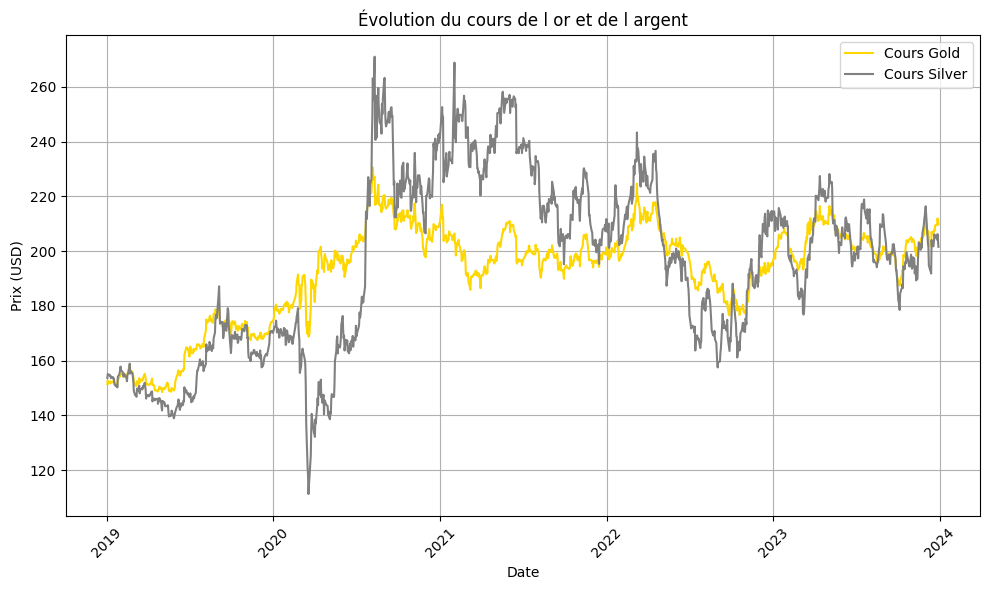

In [265]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Cours Gold'], color='gold', label='Cours Gold')
plt.plot(df['Date'], df['Cours Silver'], color='gray', label='Cours Silver')
plt.title('Évolution du cours de l or et de l argent')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [266]:
arrayDate=np.array(df['Date'])
arrayDate=arrayDate[1:]

In [267]:
arraygold = np.array(df['Cours Gold'])
arraygold=arraygold[1:]
arraysilver = np.array(df['Cours Silver'])
arraysilver=arraysilver[1:]

# Appliquer le logarithme sur les valeurs
Y = np.log(arraygold)
X = np.log(arraysilver)



# Ajouter une constante à X pour l'OLS
X = sm.add_constant(X)
# Créer le modèle OLS
model = sm.OLS(Y, X)

# Ajuster le modèle aux données
results = model.fit()

# Afficher les paramètres estimés
print(results.params)

# Ajuster la dimension de X pour qu'elle corresponde à celle de Y
X_adjusted = X[:, 1]  # Sélectionner uniquement la deuxième colonne de X
# Calculer les erreurs
alpha = results.params[0]
beta = results.params[1]

errors = Y - (alpha + X_adjusted* beta)

[2.81145775 0.46431807]


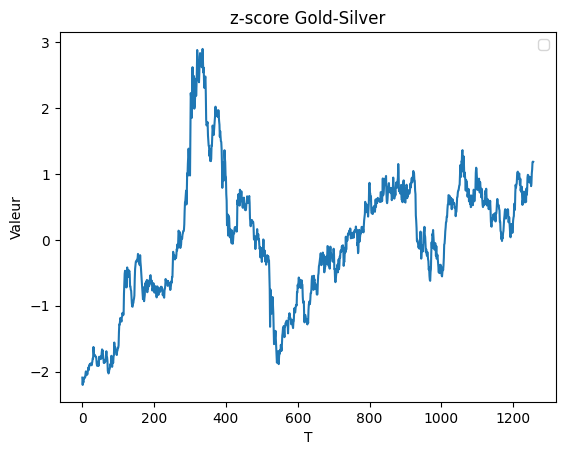

In [268]:
spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)
plt.plot(zscore)
plt.title("z-score Gold-Silver")
plt.xlabel("T")
plt.ylabel("Valeur")
plt.legend()
plt.show()

In [269]:
#Short Stratégie = Short Gold Long Silver
#Long Stratégie = Long Gold Short Silver
signal_entree_short=1
signal_entree_long=-1
signal_sortie_short=0.5
signal_sortie_long=-0.5

strat = pd.DataFrame(columns=['Date','Gold', 'Silver',"z-score" ,'short enter', 'short exit',"is short", "long enter", 'long exit',"is long","gain Gold","gain Silver","gain total","rendement Gold","rendement Silver","rendement total"])

strat.loc[0] = ["2019-01-01",0, 0,0, False,False,False, False, False, False,0,0,0,0,0,0]

for i in range(1, len(arraygold)+1):
    strat.loc[i,'Date']=arrayDate[i-1]
    strat.loc[i, 'Gold'] = arraygold[i-1]
    strat.loc[i, 'Silver'] = arraysilver[i-1]
    strat.loc[i, 'z-score'] = zscore[i-1]

    strat.loc[i,'short enter']=(strat.loc[i,'z-score']>signal_entree_short) & (strat.loc[i-1,'is short']==False)
    strat.loc[i, "short exit"] = (strat.loc[i,'z-score'] < signal_sortie_short) & (strat.loc[i-1, 'is short'])
    strat.loc[i,'is short']=(strat.loc[i,'short enter']) | ((strat.loc[i-1,"is short"]) & (strat.loc[i,"short exit"]==False))

    strat.loc[i,'long enter']=(strat.loc[i,'z-score']<signal_entree_long) & (strat.loc[i-1,'is long']==False)
    strat.loc[i, "long exit"] = (strat.loc[i,'z-score'] > signal_sortie_long) & (strat.loc[i-1, 'is long'])
    strat.loc[i,'is long']=(strat.loc[i,'long enter']) | ((strat.loc[i-1,"is long"]) & (strat.loc[i,"long exit"]==False))

    if((strat.loc[i,'is short'] & strat.loc[i-1,'is short']) | strat.loc[i,"short exit"]):
      strat.loc[i,"gain Gold"]=strat.loc[i-1,"Gold"]-strat.loc[i,"Gold"]
      strat.loc[i,"gain Silver"]=strat.loc[i,"Silver"]-strat.loc[i-1,"Silver"]
      strat.loc[i,"gain total"]=strat.loc[i,"gain Gold"]+strat.loc[i,"gain Silver"]
      strat.loc[i,"rendement Gold"]=strat.loc[i,"gain Gold"]/strat.loc[i-1,"Gold"]
      strat.loc[i,"rendement Silver"]=strat.loc[i,"gain Silver"]/strat.loc[i-1,"Silver"]
      strat.loc[i,"rendement total"]=(strat.loc[i,"rendement Gold"]+strat.loc[i,"rendement Silver"])/2

    elif((strat.loc[i,'is long'] & strat.loc[i-1,'is long'])| strat.loc[i,"long exit"]):
      strat.loc[i,"gain Gold"]=strat.loc[i,"Gold"]-strat.loc[i-1,"Gold"]
      strat.loc[i,"gain Silver"]=strat.loc[i-1,"Silver"]-strat.loc[i,"Silver"]
      strat.loc[i,"gain total"]=strat.loc[i,"gain Gold"]+strat.loc[i,"gain Silver"]
      strat.loc[i,"rendement Gold"]=strat.loc[i,"gain Gold"]/strat.loc[i-1,"Gold"]
      strat.loc[i,"rendement Silver"]=strat.loc[i,"gain Silver"]/strat.loc[i-1,"Silver"]
      strat.loc[i,"rendement total"]=(strat.loc[i,"rendement Gold"]+strat.loc[i,"rendement Silver"])/2

    else:
      strat.loc[i,"gain Gold"]=0
      strat.loc[i,"gain Silver"]=0
      strat.loc[i,"gain total"]=0
      strat.loc[i,"rendement Gold"]=0
      strat.loc[i,"rendement Silver"]=0
      strat.loc[i,"rendement total"]=0


strat.to_excel("strat.xlsx", index=False)


In [270]:
strat['cumulative_returns'] = (strat["rendement total"]+1).cumprod()-1

In [271]:
strat['Date'] = pd.to_datetime(strat['Date'])

In [272]:
import plotly.graph_objs as go

# Créer la figure
fig = go.Figure()

# Ajouter la série de données des rendements composés
fig.add_trace(go.Scatter(x=strat['Date'], y=strat['cumulative_returns'], mode='lines', name='Rendements composés', line=dict(color='blue', width=2)))

# Mettre en forme le titre et les étiquettes des axes
fig.update_layout(title='Rendements composés dans le temps',
                   xaxis_title='Date',
                   yaxis_title='Rendements composés')

# Afficher le graphique
fig.show()

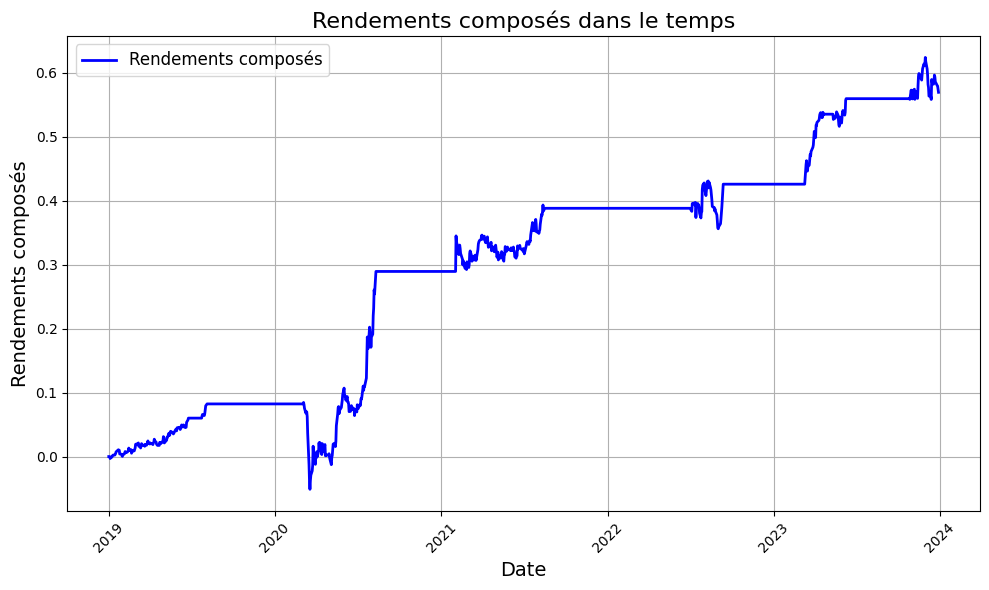

In [273]:
# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(strat['Date'], strat['cumulative_returns'], color='blue', label='Rendements composés', linewidth=2)
plt.title('Rendements composés dans le temps', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rendements composés', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajustement automatique des marges
plt.show()

In [274]:
df_2019 = strat[strat['Date'].dt.year == 2019]
df_2020 = strat[strat['Date'].dt.year == 2020]
df_2021 = strat[strat['Date'].dt.year == 2021]
df_2022 = strat[strat['Date'].dt.year == 2022]
df_2023 = strat[strat['Date'].dt.year == 2023]

In [275]:
def ann_return(returns):
  mu=np.mean(returns)
  ann_return=(1+mu)**(len(returns))-1
  return ann_return

In [276]:
def Compute_Vol(returns):
    mu = np.mean(returns)  # Calculer la moyenne
    sigma_daily = np.sqrt(np.sum((returns - mu)**2) / (len(returns) - 1))  # Calcul de l'écart-type quotidien
    sigma = np.sqrt(len(returns)) * sigma_daily  # Multiple d'annualisation
    return sigma

In [277]:
def sharpe_ratio(returns,rf=0):
  ret=ann_return(returns)
  vol=Compute_Vol(returns)
  return (ret-rf)/vol

In [278]:
def max_drawdown(returns):
    valeurs_cumulees = (1 + returns).cumprod()  # Calcul des valeurs cumulées
    max_cumule = valeurs_cumulees.cummax()  # Maximum cumulé jusqu'à cette période
    drawdown = (valeurs_cumulees / max_cumule) - 1  # Drawdown pour chaque période
    max_drawdown = drawdown.min()  # Drawdown maximum

    return max_drawdown

In [279]:
results = pd.DataFrame(columns=['Year','Ann return','Volatility','Sharpe Ratio','Max Drawdown'])

In [280]:
ann_return_2019 = ann_return(df_2019['rendement total'])
volatility_2019 = Compute_Vol(df_2019['rendement total'])
sharpe_ratio_2019 = sharpe_ratio(df_2019['rendement total'])
max_drawdown_2019 = max_drawdown(df_2019['rendement total'])

results.loc[0] = ["2019", ann_return_2019, volatility_2019, sharpe_ratio_2019, max_drawdown_2019]
#On considère un risk free de 0 en 2019

In [281]:
ann_return_2020 = ann_return(df_2020['rendement total'])
volatility_2020 = Compute_Vol(df_2020['rendement total'])
sharpe_ratio_2020 = sharpe_ratio(df_2020['rendement total'])
max_drawdown_2020 = max_drawdown(df_2020['rendement total'])
results.loc[1] = ["2020", ann_return_2020, volatility_2020, sharpe_ratio_2020, max_drawdown_2020]
#On considère un risk free de 0 en 202O

In [282]:
ann_return_2021 = ann_return(df_2021['rendement total'])
volatility_2021 = Compute_Vol(df_2021['rendement total'])
sharpe_ratio_2021 = sharpe_ratio(df_2021['rendement total'])
max_drawdown_2021 = max_drawdown(df_2021['rendement total'])

results.loc[2] = ["2021", ann_return_2021, volatility_2021, sharpe_ratio_2021, max_drawdown_2021]
#On considère un risk free de 0 en 2021

In [283]:
ann_return_2022 = ann_return(df_2022['rendement total'])
volatility_2022 = Compute_Vol(df_2022['rendement total'])
sharpe_ratio_2022 = sharpe_ratio(df_2022['rendement total'])
max_drawdown_2022 =max_drawdown(df_2022['rendement total'])

results.loc[3] = ["2022", ann_return_2022, volatility_2022, sharpe_ratio_2022, max_drawdown_2022]
#On considère un risk free de 0 en 2022

In [284]:
ann_return_2023 = ann_return(df_2023['rendement total'])
volatility_2023 = Compute_Vol(df_2023['rendement total'])
sharpe_ratio_2023 = sharpe_ratio(df_2023['rendement total'],0.025)
max_drawdown_2023 = max_drawdown(df_2023['rendement total'])

results.loc[4] = ["2023", ann_return_2023, volatility_2023, sharpe_ratio_2023, max_drawdown_2023]
#On considère un risk free de 2.5% en 2023

In [287]:
results.head()
results.to_excel("results.xlsx", index=False)